In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import linear, relu
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [2]:
tf.random.set_seed(1)

In [3]:
# SEED = 0

# def set_seeds(seed=SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)
    
# def set_global_determinism(seed=SEED):
#     set_seeds(seed=seed)

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)

# # Call the above function with seed value
# set_global_determinism(seed=SEED)

In [4]:
df = pd.read_excel('dataset/cleaned_data/cleaned_building_v2.xlsx')

In [5]:
df['price'].max(), df['price'].min()

(35000000000, 250000)

In [6]:
df = df.drop(df.sort_values(by='price', ascending=True).head(200).index.values.tolist())
df = df.drop(df.sort_values(by='price', ascending=False).head(1000).index.values.tolist())

df = df.drop(df.sort_values(by='Потолки', ascending=False).head(10).index.values.tolist())

df = df.drop(df.sort_values(by='Общая площадь, м²', ascending=True).head(160).index.values.tolist())
df = df.drop(df.sort_values(by='Общая площадь, м²', ascending=False).head(40).index.values.tolist())

In [7]:
df['price'].max(), df['price'].min()

(400000000, 18000000)

In [8]:
df = df.drop(df[df['статус']== 0].index.values.tolist())
df = df.drop(df[df['статус']== -1].index.values.tolist())

In [9]:
# df = df.drop(['region', 'nan', 'В залоге', 'Состояние', 
#               'решетки на окнах', 'через TV кабель', 'регион', 'статус', 'проводной'], axis=1)
# df = df.drop(['region', 'nan', 'В залоге', 'Кол-во телефонных линий', 'через TV кабель', 'ADSL', 'проводной', 'регион', 'статус'], axis=1)

df = df.drop(['решетки на окнах', 'Год постройки (сдачи в эксплуатацию)','region', 'nan', 'В залоге', 'Кол-во телефонных линий', 'через TV кабель', 'ADSL', 'проводной', 'регион', 'статус'], axis=1)
df = df.astype(float)

In [10]:
# df['price'] = df['price'] / df['Общая площадь, м²']
df['price'] = np.log1p(df['price'])

In [11]:
df = df.reset_index(drop=True)
df

,"Общая площадь, м²",Количество уровней,Тип строения,Состояние,Потолки,price,Парковка,пожарная сигнализация,круглосуточная охрана,видеонаблюдение,сигнализация,оптика
0,214.0,1.0,1.0,2.0,2.700000,19.519293,0.0,0.0,0.0,0.0,0.0,1.0
1,550.0,1.0,1.0,2.0,3.546487,18.064006,1.0,0.0,0.0,0.0,0.0,1.0
2,600.0,1.0,1.0,-1.0,3.800000,18.534009,1.0,0.0,0.0,1.0,0.0,1.0
3,400.0,1.0,1.0,4.0,4.200000,19.088510,1.0,1.0,1.0,1.0,1.0,1.0
4,2512.0,4.0,4.0,4.0,2.700000,19.701612,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2920,273.7,2.0,-1.0,-1.0,3.500000,17.569710,1.0,0.0,0.0,0.0,0.0,0.0
2921,185.0,1.0,1.0,4.0,3.546487,17.504390,0.0,0.0,0.0,0.0,0.0,0.0
2922,850.0,3.0,1.0,4.0,5.000000,19.368470,1.0,1.0,1.0,1.0,1.0,0.0
2923,600.0,2.0,1.0,4.0,3.546487,18.105970,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,"Общая площадь, м²",Количество уровней,Тип строения,Состояние,Потолки,price,Парковка,пожарная сигнализация,круглосуточная охрана,видеонаблюдение,сигнализация,оптика
"Общая площадь, м²",1.000000,0.358939,0.057567,-0.005014,0.129538,0.438098,0.013403,0.036897,0.106112,0.030017,0.019433,0.007783
Количество уровней,0.358939,1.000000,0.056868,-0.039091,-0.125497,0.351948,-0.038585,0.043853,0.033347,0.020054,0.037022,0.077919
Тип строения,0.057567,0.056868,1.000000,0.128193,0.061756,0.047905,0.108970,0.078898,0.094215,0.076022,0.088454,0.032100
Состояние,-0.005014,-0.039091,0.128193,1.000000,-0.043928,0.020814,0.213566,0.205680,0.148918,0.234843,0.224825,0.037293
Потолки,0.129538,-0.125497,0.061756,-0.043928,1.000000,0.022370,-0.057141,-0.082731,0.010346,-0.031184,-0.072420,-0.032005
price,0.438098,0.351948,0.047905,0.020814,0.022370,1.000000,0.061606,0.178394,0.175655,0.190946,0.181549,0.114330
Парковка,0.013403,-0.038585,0.108970,0.213566,-0.057141,0.061606,1.000000,0.294953,0.249056,0.331917,0.309402,0.122301
пожарная сигнализация,0.036897,0.043853,0.078898,0.205680,-0.082731,0.178394,0.294953,1.000000,0.449582,0.634334,0.918174,0.150874
круглосуточная охрана,0.106112,0.033347,0.094215,0.148918,0.010346,0.175655,0.249056,0.449582,1.000000,0.460021,0.462393,0.104273
видеонаблюдение,0.030017,0.020054,0.076022,0.234843,-0.031184,0.190946,0.331917,0.634334,0.460021,1.000000,0.667563,0.158136


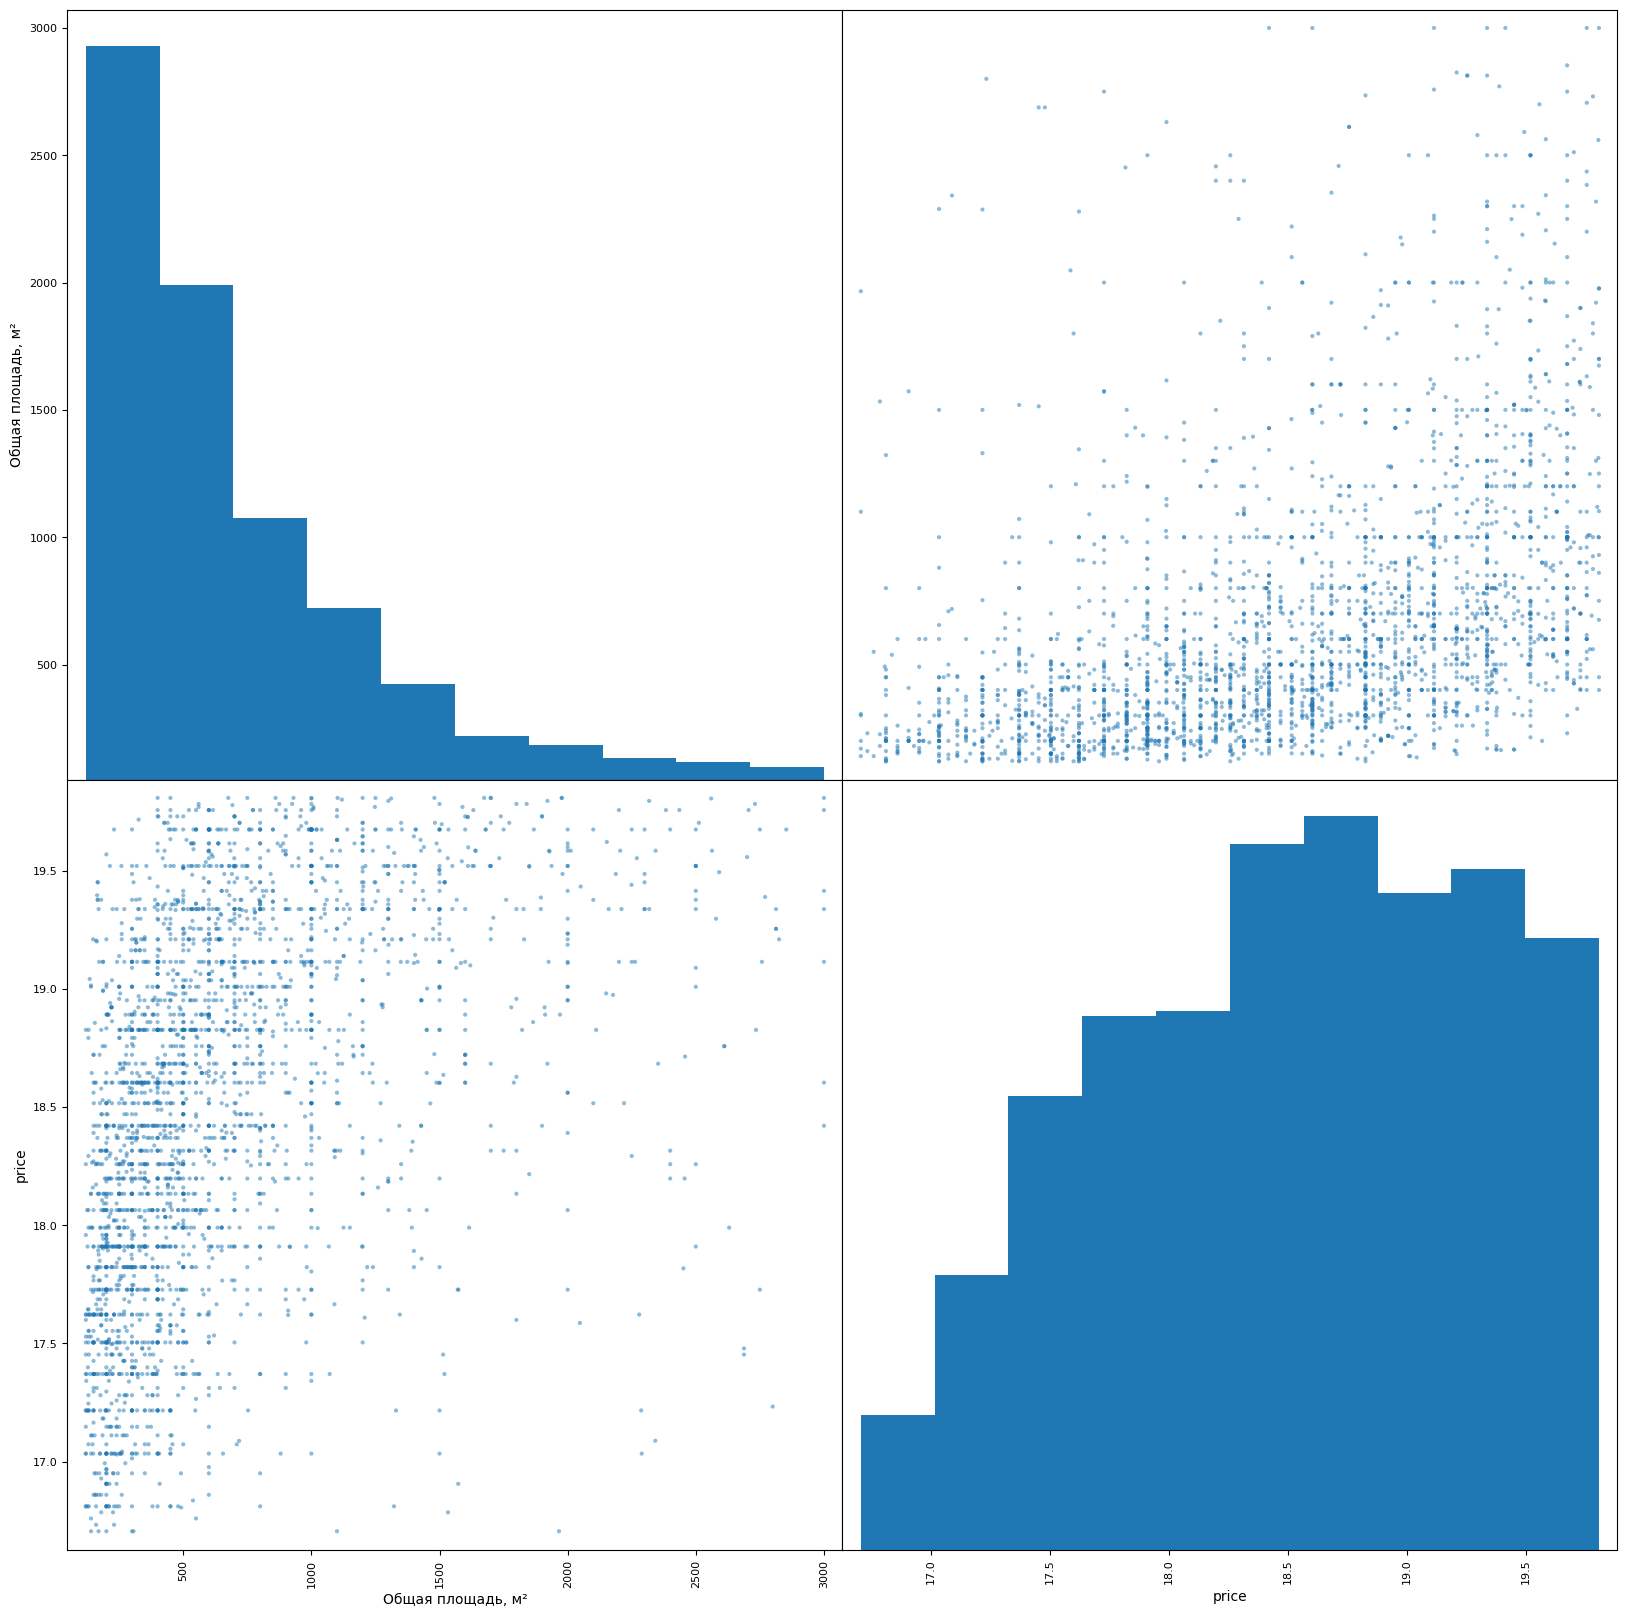

In [13]:
pd.plotting.scatter_matrix(df[['Общая площадь, м²', 'price']], diagonal='hist', figsize=(20,20))
plt.show()

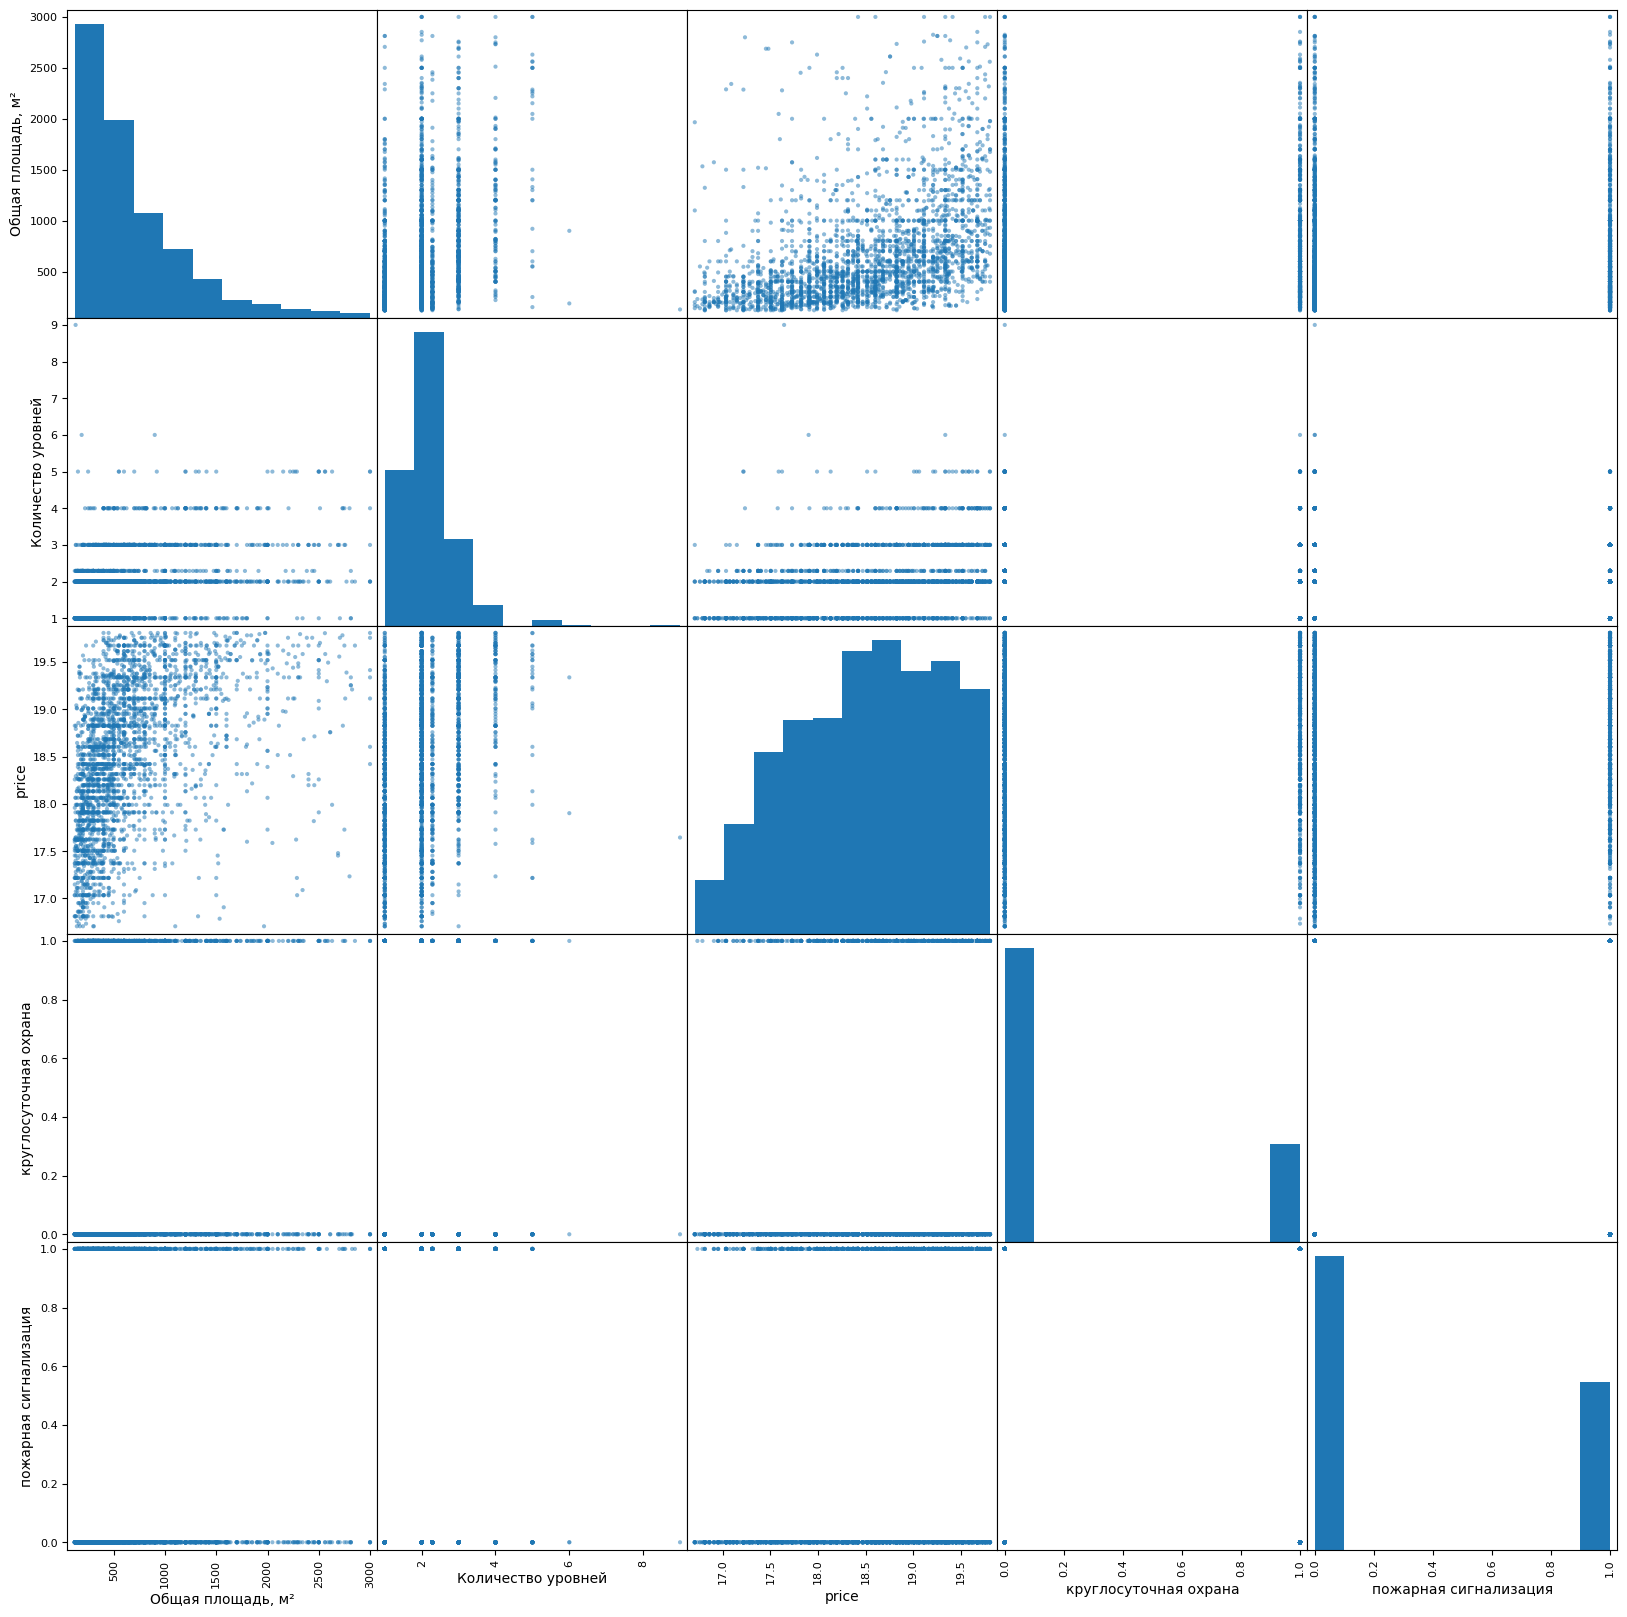

In [14]:
pd.plotting.scatter_matrix(df[['Общая площадь, м²', 'Количество уровней', 'price', 'круглосуточная охрана', 'пожарная сигнализация']], diagonal='hist', figsize=(20,20))
plt.show()

In [15]:
X = df.drop(['price'], axis=1)
y = df['price']

In [16]:
Scaler = StandardScaler()
# Scaler = MinMaxScaler()
mse = MeanSquaredError()
mae = MeanAbsoluteError()

In [17]:
X = Scaler.fit_transform(X)

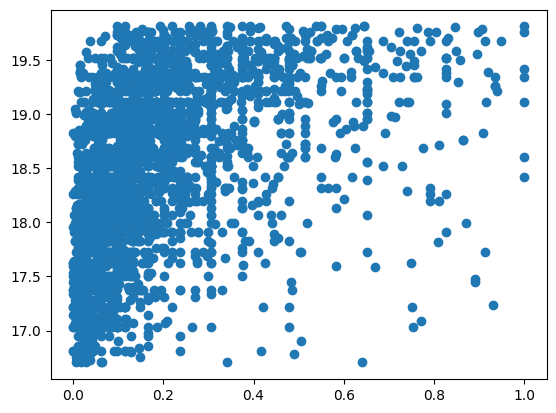

In [23]:
plt.scatter(MinMaxScaler().fit_transform(tf.reshape(df['Общая площадь, м²'], shape=(-1,1))), y)

In [24]:
X_train, _1 , y_train, _2 = train_test_split(X,y, test_size=0.1)
X_test, X_val, y_test, y_val = train_test_split(_1, _2, test_size=0.5)

print(X_train.shape, X_val.shape, X_test.shape)

(2632, 11) (147, 11) (146, 11)


In [25]:
checkpoint_filepath = r"C:\Users\karib\Desktop\diploma\models\model_v2"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_absolute_error',
    mode='min',
    save_best_only=True)

In [26]:
callback_patience = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [27]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    return lr / (1 + 0.0001 * epoch)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

lr = 2.3
for i in range(100):
    lr = scheduler(i, lr)
#     print(lr, i)

In [28]:
class SimpleQuadratic(tf.keras.layers.Layer):

    def __init__(self, units=32, activation=None):
        '''Initializes the class and sets up the internal variables'''
        super(SimpleQuadratic, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # a and b should be initialized with random normal, c (or the bias) with zeros.
        # remember to set these as trainable.
        a_init = tf.random_normal_initializer()
        self.a = tf.Variable(initial_value=a_init(shape=(input_shape[-1], self.units), dtype='float32'), trainable=True)
        
        b_init = tf.random_normal_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(input_shape[-1], self.units), dtype='float32'), trainable=True)
        
        c_init = tf.zeros_initializer()
        self.c = tf.Variable(initial_value=c_init(shape=self.units, dtype='float32'), trainable=True)
        
   
    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        # Remember to use self.activation() to get the final output
        # x^2*a + x*b + c
        
        x_squared = tf.math.square(inputs)
        x_squared_times_a = tf.matmul(x_squared, self.a)
        
        x_times_b = tf.matmul(inputs, self.b)
        
        x2a_plus_xb_plus_c = x_squared_times_a + x_times_b + self.c
        
        return self.activation(x2a_plus_xb_plus_c)

In [29]:
class Model(tf.keras.Model):
    def __init__(self, units=32, activation='relu', **kwargs):
        super().__init__(**kwargs)
        
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        
        self.hidden3 = Dense(units, activation=activation)
        self.hidden4 = Dense(units, activation=activation)
        
        self.hidden5 = Dense(units, activation=activation)
        self.hidden6 = Dense(units, activation=activation)
        
        self.hidden7 = Dense(units, activation=activation)
        self.hidden8 = Dense(units * 2, activation=activation)
        
        self.batch_normalization = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.add = tf.keras.layers.Add()
        self.multiply = tf.keras.layers.Multiply()
    
        self.main_output = Dense(1)
        
    def call(self, input):
        
        x_1 = self.hidden1(input)
        x = self.hidden2(x_1)
        
        x = self.dropout(x)
        
        x = self.add([x, x_1])
        
        x =  self.multiply([x, x])
        
        x = self.hidden3(x)
        x = self.hidden4(x)
        
        x_5 = self.hidden5(x)
        x = self.hidden6(x_5)
        
        x = self.batch_normalization(x)
        x = self.dropout(x)
        
        x = self.add([x, x_5])
        
        x =  self.multiply([x, x])
        
        x = self.hidden7(x)
        x = self.hidden8(x)
        
        main_output = self.main_output(x)
        return main_output


In [30]:
model = Model()

In [31]:
# ADAM 16
# RMSprop 16 with log
optimizers = ["Adam", "SGD", "RMSprop"]
batch_size = [16, 32, 64, 128, 256]

for i, optimizer in enumerate(optimizers):
    for j, batch in enumerate(batch_size):
        print(batch, optimizer)
        exec(f"model{i}_{j} = Model()")
        exec(f"model{i}_{j}.compile(optimizer=tf.keras.optimizers.{optimizer}(), loss='mae')")
        exec(f"model{i}_{j}.fit(X_train, y_train, epochs=300, batch_size={batch}, callbacks = [callback_patience], validation_data=(X_val, y_val))")

16 Adam
Epoch 1/300
165/165 [==============================] - 8s 26ms/step - loss: 9.4146 - val_loss: 12.0743
Epoch 2/300
165/165 [==============================] - 4s 22ms/step - loss: 4.5172 - val_loss: 5.1920
Epoch 3/300
165/165 [==============================] - 4s 22ms/step - loss: 3.4043 - val_loss: 3.0764
Epoch 4/300
165/165 [==============================] - 4s 22ms/step - loss: 2.5618 - val_loss: 2.2144
Epoch 5/300
165/165 [==============================] - 4s 22ms/step - loss: 1.8233 - val_loss: 1.2560
Epoch 6/300
165/165 [==============================] - 4s 22ms/step - loss: 1.2952 - val_loss: 0.9764
Epoch 7/300
165/165 [==============================] - 4s 22ms/step - loss: 0.9222 - val_loss: 0.8142
Epoch 8/300
165/165 [==============================] - 4s 22ms/step - loss: 0.7569 - val_loss: 0.6250
Epoch 9/300
165/165 [==============================] - 4s 22ms/step - loss: 0.7070 - val_loss: 0.6165
Epoch 10/300
165/165 [==============================] - 4s 22ms/step - lo

165/165 [==============================] - 4s 22ms/step - loss: 0.4526 - val_loss: 0.5684
Epoch 81/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4566 - val_loss: 0.6176
Epoch 82/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4426 - val_loss: 0.5688
Epoch 83/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4403 - val_loss: 0.5653
Epoch 84/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4460 - val_loss: 0.5949
Epoch 85/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4393 - val_loss: 0.5689
Epoch 86/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4347 - val_loss: 0.6208
Epoch 87/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4363 - val_loss: 0.5871
Epoch 88/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4369 - val_loss: 0.5884
Epoch 89/300
165/165 [==============================] - 4s 22ms/step - loss: 0.4367 - 

Epoch 2/300
42/42 [==============================] - 1s 22ms/step - loss: 12.7201 - val_loss: 15.0101
Epoch 3/300
42/42 [==============================] - 1s 23ms/step - loss: 7.8569 - val_loss: 13.2910
Epoch 4/300
42/42 [==============================] - 1s 22ms/step - loss: 4.6528 - val_loss: 12.0995
Epoch 5/300
42/42 [==============================] - 1s 22ms/step - loss: 3.4692 - val_loss: 10.9384
Epoch 6/300
42/42 [==============================] - 1s 22ms/step - loss: 2.9627 - val_loss: 9.4693
Epoch 7/300
42/42 [==============================] - 1s 22ms/step - loss: 2.7565 - val_loss: 8.6897
Epoch 8/300
42/42 [==============================] - 1s 22ms/step - loss: 2.4313 - val_loss: 6.9969
Epoch 9/300
42/42 [==============================] - 1s 22ms/step - loss: 2.3568 - val_loss: 5.7415
Epoch 10/300
42/42 [==============================] - 1s 22ms/step - loss: 2.3057 - val_loss: 4.9288
Epoch 11/300
42/42 [==============================] - 1s 22ms/step - loss: 2.0111 - val_loss: 

Epoch 39/300
21/21 [==============================] - 0s 23ms/step - loss: 0.7432 - val_loss: 0.7070
Epoch 40/300
21/21 [==============================] - 0s 24ms/step - loss: 0.7103 - val_loss: 0.6952
Epoch 41/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6935 - val_loss: 0.8734
Epoch 42/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6834 - val_loss: 0.7547
Epoch 43/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6511 - val_loss: 0.6809
Epoch 44/300
21/21 [==============================] - 0s 23ms/step - loss: 0.6404 - val_loss: 0.6190
Epoch 45/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6237 - val_loss: 0.6084
Epoch 46/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6691 - val_loss: 0.6880
Epoch 47/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6380 - val_loss: 0.7619
Epoch 48/300
21/21 [==============================] - 0s 24ms/step - loss: 0.6012 - val_los

Epoch 50/300
11/11 [==============================] - 0s 26ms/step - loss: 1.2077 - val_loss: 2.3822
Epoch 51/300
11/11 [==============================] - 0s 26ms/step - loss: 1.1475 - val_loss: 1.7473
Epoch 52/300
11/11 [==============================] - 0s 25ms/step - loss: 1.1518 - val_loss: 2.0814
Epoch 53/300
11/11 [==============================] - 0s 26ms/step - loss: 1.1547 - val_loss: 1.5138
Epoch 54/300
11/11 [==============================] - 0s 26ms/step - loss: 1.2347 - val_loss: 1.6710
Epoch 55/300
11/11 [==============================] - 0s 25ms/step - loss: 1.1746 - val_loss: 1.5742
Epoch 56/300
11/11 [==============================] - 0s 25ms/step - loss: 1.1608 - val_loss: 2.0496
16 SGD
Epoch 1/300
165/165 [==============================] - 5s 22ms/step - loss: 7.8328 - val_loss: 9.0088
Epoch 2/300
165/165 [==============================] - 3s 21ms/step - loss: 3.2118 - val_loss: 2.4264
Epoch 3/300
165/165 [==============================] - 3s 21ms/step - loss: 2.1143

42/42 [==============================] - 1s 22ms/step - loss: 2.1933 - val_loss: 3.3932
Epoch 11/300
42/42 [==============================] - 1s 21ms/step - loss: 1.9812 - val_loss: 1.4266
Epoch 12/300
42/42 [==============================] - 1s 22ms/step - loss: 1.9513 - val_loss: 2.6054
Epoch 13/300
42/42 [==============================] - 1s 22ms/step - loss: 1.9402 - val_loss: 0.8858
Epoch 14/300
42/42 [==============================] - 1s 22ms/step - loss: 1.7900 - val_loss: 1.4122
Epoch 15/300
42/42 [==============================] - 1s 22ms/step - loss: 1.8063 - val_loss: 0.9999
Epoch 16/300
42/42 [==============================] - 1s 22ms/step - loss: 1.6114 - val_loss: 1.7192
Epoch 17/300
42/42 [==============================] - 1s 22ms/step - loss: 1.7323 - val_loss: 1.5977
Epoch 18/300
42/42 [==============================] - 1s 22ms/step - loss: 1.5062 - val_loss: 1.4230
Epoch 19/300
42/42 [==============================] - 1s 22ms/step - loss: 1.4013 - val_loss: 0.9292
Epo

11/11 [==============================] - 0s 25ms/step - loss: 2.1525 - val_loss: 6.4643
Epoch 22/300
11/11 [==============================] - 0s 24ms/step - loss: 2.5380 - val_loss: 8.7262
Epoch 23/300
11/11 [==============================] - 0s 25ms/step - loss: 2.4406 - val_loss: 6.7554
Epoch 24/300
11/11 [==============================] - 0s 24ms/step - loss: 2.4131 - val_loss: 8.3614
Epoch 25/300
11/11 [==============================] - 0s 25ms/step - loss: 1.9547 - val_loss: 6.8809
Epoch 26/300
11/11 [==============================] - 0s 25ms/step - loss: 2.4133 - val_loss: 8.4784
Epoch 27/300
11/11 [==============================] - 0s 25ms/step - loss: 2.1353 - val_loss: 5.3325
Epoch 28/300
11/11 [==============================] - 0s 24ms/step - loss: 2.5627 - val_loss: 8.6232
Epoch 29/300
11/11 [==============================] - 0s 24ms/step - loss: 2.3759 - val_loss: 6.3973
Epoch 30/300
11/11 [==============================] - 0s 24ms/step - loss: 2.1687 - val_loss: 7.8030
16 

Epoch 71/300
165/165 [==============================] - 6s 39ms/step - loss: 0.4420 - val_loss: 0.5536
Epoch 72/300
165/165 [==============================] - 7s 41ms/step - loss: 0.4439 - val_loss: 0.6234
Epoch 73/300
165/165 [==============================] - 7s 41ms/step - loss: 0.4357 - val_loss: 0.5690
Epoch 74/300
165/165 [==============================] - 6s 39ms/step - loss: 0.4406 - val_loss: 0.6932
Epoch 75/300
165/165 [==============================] - 6s 39ms/step - loss: 0.4323 - val_loss: 0.5405
Epoch 76/300
165/165 [==============================] - 7s 40ms/step - loss: 0.4341 - val_loss: 0.5630
Epoch 77/300
165/165 [==============================] - 7s 40ms/step - loss: 0.4332 - val_loss: 0.5753
Epoch 78/300
165/165 [==============================] - 6s 39ms/step - loss: 0.4360 - val_loss: 0.6585
Epoch 79/300
165/165 [==============================] - 7s 41ms/step - loss: 0.4292 - val_loss: 0.5648
Epoch 80/300
165/165 [==============================] - 7s 42ms/step - lo

83/83 [==============================] - 3s 37ms/step - loss: 0.6034 - val_loss: 0.5963
Epoch 39/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5850 - val_loss: 0.7160
Epoch 40/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5705 - val_loss: 1.2126
Epoch 41/300
83/83 [==============================] - 3s 38ms/step - loss: 0.5740 - val_loss: 0.5990
Epoch 42/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5653 - val_loss: 0.7453
Epoch 43/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5619 - val_loss: 0.6802
Epoch 44/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5581 - val_loss: 0.7330
Epoch 45/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5507 - val_loss: 0.5414
Epoch 46/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5471 - val_loss: 0.5320
Epoch 47/300
83/83 [==============================] - 3s 37ms/step - loss: 0.5382 - val_loss: 0.5591
Epo

21/21 [==============================] - 1s 40ms/step - loss: 2.6370 - val_loss: 7.9616
Epoch 12/300
21/21 [==============================] - 1s 41ms/step - loss: 2.4139 - val_loss: 6.7297
Epoch 13/300
21/21 [==============================] - 1s 40ms/step - loss: 2.3277 - val_loss: 6.4310
Epoch 14/300
21/21 [==============================] - 1s 41ms/step - loss: 2.2627 - val_loss: 5.0361
Epoch 15/300
21/21 [==============================] - 1s 41ms/step - loss: 2.1456 - val_loss: 4.5941
Epoch 16/300
21/21 [==============================] - 1s 41ms/step - loss: 2.1945 - val_loss: 4.2100
Epoch 17/300
21/21 [==============================] - 1s 41ms/step - loss: 2.2466 - val_loss: 4.3430
Epoch 18/300
21/21 [==============================] - 1s 42ms/step - loss: 2.0549 - val_loss: 4.6953
Epoch 19/300
21/21 [==============================] - 1s 41ms/step - loss: 1.9495 - val_loss: 4.4818
Epoch 20/300
21/21 [==============================] - 1s 42ms/step - loss: 1.9022 - val_loss: 2.9199
Epo

Epoch 65/300
11/11 [==============================] - 0s 43ms/step - loss: 1.1797 - val_loss: 0.8553
Epoch 66/300
11/11 [==============================] - 0s 43ms/step - loss: 1.2007 - val_loss: 1.9971
Epoch 67/300
11/11 [==============================] - 0s 45ms/step - loss: 1.3129 - val_loss: 1.0745
Epoch 68/300
11/11 [==============================] - 0s 44ms/step - loss: 1.1837 - val_loss: 1.9286
Epoch 69/300
11/11 [==============================] - 0s 44ms/step - loss: 1.3250 - val_loss: 1.9631
Epoch 70/300
11/11 [==============================] - 0s 44ms/step - loss: 1.2509 - val_loss: 0.9226


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

history = model.fit(
                    X_train, y_train, epochs=300, batch_size=64,
                    callbacks = [callback_patience], 
                    validation_data=(X_val, y_val)
                   )

In [38]:
for i in range(3):
    for j in range(5):
        print(f"model{i}_{j}")
        
        exec(f"y_pred = model{i}_{j}.predict(X)")
        exec(f"y_pred = tf.math.exp(y_pred)")
        exec(f"y_true = tf.math.exp(y)")
        exec(f"print(mae(y_true, y_pred))")
        
        exec(f"y_pred_train = model{i}_{j}.predict(X_train)")
        exec(f"y_pred_test = model{i}_{j}.predict(X_test)")
    
        exec(f"print(f'Mean Absolute Error - test: {mae(tf.math.exp(y_test), tf.math.exp(y_pred_test))}')")
        exec(f"print(f'Mean Absolute Error - train: {mae(tf.math.exp(y_train), tf.math.exp(y_pred_train))}')")


model0_0
92/92 [==============================] - 1s 7ms/step
tf.Tensor(550204540.0, shape=(), dtype=float32)
5/5 [==============================] - 0s 6ms/step
Mean Absolute Error - test: 77651712.0
Mean Absolute Error - train: 603103488.0
model0_1
92/92 [==============================] - 1s 6ms/step
tf.Tensor(64103320.0, shape=(), dtype=float32)
5/5 [==============================] - 0s 7ms/step
Mean Absolute Error - test: 84925016.0
Mean Absolute Error - train: 62140380.0
model0_2
92/92 [==============================] - 1s 6ms/step
tf.Tensor(66153190.0, shape=(), dtype=float32)
5/5 [==============================] - 0s 7ms/step
Mean Absolute Error - test: 79901064.0
Mean Absolute Error - train: 65079620.0
model0_3
92/92 [==============================] - 1s 6ms/step
tf.Tensor(77174800.0, shape=(), dtype=float32)
5/5 [==============================] - 0s 6ms/step
Mean Absolute Error - test: 92840256.0
Mean Absolute Error - train: 75914776.0
model0_4
92/92 [==========================

In [39]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 12ms/step - loss: 0.5527


0.5527490973472595

In [40]:
model.evaluate(X_train, y_train)

83/83 [==============================] - 1s 10ms/step - loss: 0.3693


0.3693453073501587

In [41]:
y_pred_train = model.predict(X_train)
# y_pred_train = y_pred_train - (y_pred_train % 100000)

y_pred_test = model.predict(X_test)
# y_pred_test = y_pred_test - (y_pred_test % 100000)

print(f"Mean Squared Error - train: {tf.math.sqrt(mse(y_train, y_pred_train))}")
print(f"Mean Squared Error - test: {tf.math.sqrt(mse(y_test, y_pred_test))}\n")

print(f"Mean Absolute Error - train: {mae(y_test, y_pred_test)}")
print(f"Mean Absolute Error - test: {mae(y_train, y_pred_train)}\n")

print(f"Mean Absolute Error - test: {mae(tf.math.exp(y_test), tf.math.exp(y_pred_test))}")
print(f"Mean Absolute Error - train: {mae(tf.math.exp(y_train), tf.math.exp(y_pred_train))}")

5/5 [==============================] - 0s 7ms/step
Mean Squared Error - train: 1.0112546682357788
Mean Squared Error - test: 0.9504079818725586

Mean Absolute Error - train: 0.7730270028114319
Mean Absolute Error - test: 0.8210510611534119

Mean Absolute Error - test: 75746000.0
Mean Absolute Error - train: 45772428.0


In [42]:
print(f"Mean Absolute Error - test: {mae(tf.math.exp(y_test), tf.math.exp(y_pred_test))}")
print(f"Mean Absolute Error - train: {mae(tf.math.exp(y_train), tf.math.exp(y_pred_train))}")

Mean Absolute Error - test: 75746000.0
Mean Absolute Error - train: 45772428.0


In [ ]:
# for i in range(100):
#     print(f"Mean Absolute Error - test: {mae(tf.math.exp(y_test), tf.math.exp(y_pred_test-1/100 * i))}", i)

In [ ]:
history_df = pd.DataFrame(history.history)

In [ ]:
history_df.plot(figsize=(5,5))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# model.get_weights()

In [ ]:
for i in range(3):
    for j in range(5):
        exec(f"plt.scatter(df['Общая площадь, м²'], y, c='b', label='trainin_data')")
        exec(f"plt.scatter(df['Общая площадь, м²'], model{i}_{j}.predict(X), c='r', label='predicted_data')")
        exec(f"plt.legend()")
        exec(f"plt.show()")

92/92 [==============================] - 1s 7ms/step


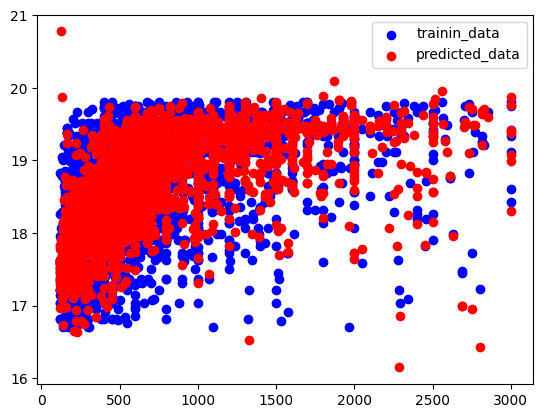

In [43]:
# plt.figure(figsize=(7,4))
plt.scatter(df['Общая площадь, м²'], y, c='b', label='trainin_data')
plt.scatter(df['Общая площадь, м²'], model.predict(X), c='r', label='predicted_data')
plt.legend()

In [ ]:
index = 30
for i in ['Общая площадь, м²', 'Количество уровней', 'круглосуточная охрана', 'пожарная сигнализация']:
    plt.figure(figsize=(7,4))
    plt.scatter(df[i][:index],y[:index], c='b', label='trainin_data')
    plt.scatter(df[i][:index], model.predict(X[:index]), c='r', label='predicted_data')
    plt.legend()

In [45]:
model2_0.save(r'C:\Users\karib\Desktop\diploma\models\model_v2')

INFO:tensorflow:Assets written to: C:\Users\karib\Desktop\diploma\models\model_v2\assets


In [ ]:
y_pred = model.predict(X)
y_true = y

mae(y_true, y_pred)

In [ ]:
y_pred = model.predict(X)
y_pred = tf.math.exp(y_pred)

y_true = tf.math.exp(y)

mae(y_true, y_pred)

In [ ]:
# fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df.corr(), annot=True, 
#             cmap='coolwarm')
# plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [ ]:
model.summary()

In [ ]:
model.predict(np.expand_dims(X_train[0], 0))[0][0], y_train[0]

In [50]:
nn = tf.keras.models.load_model(r'C:\Users\karib\Desktop\diploma\models\model_v2')

In [56]:
nn.get_weights()

[array([[ 0.06015536,  0.3801513 , -0.1331302 , -0.6438075 , -0.53638947,
          0.24462977, -0.00937195,  0.11555746,  0.20482196,  0.11981376,
         -0.2367346 , -0.09633987, -0.0678663 , -0.8178278 ,  0.09898929,
          0.16334578, -0.20262074,  0.34417433,  0.08614296, -0.4978077 ,
          0.13201177, -0.29120567,  0.30359113, -0.30954924, -0.07016653,
         -0.48433176,  0.07692301,  0.11611474, -0.05988727, -0.01660188,
          0.12448344, -0.04297287],
        [-0.38772127,  0.29607823,  0.26611033, -0.04444559, -0.08405513,
          0.17890121,  0.21551764, -0.01035733, -0.12125105,  0.00142907,
          0.12557614, -0.5116744 , -0.1327551 ,  0.09165074,  0.3064959 ,
         -0.22861876, -0.31777814, -0.17614895,  0.1552835 , -0.10390329,
          0.06805403,  0.13447674,  0.00957016, -0.12851258,  0.28100556,
         -0.2851788 ,  0.01908844, -0.245821  , -0.09922256,  0.2965682 ,
         -0.03724258, -0.20953983],
        [ 0.16605422,  0.02560099,  0.36

In [55]:
nn.predict(X)

NotImplementedError: in user code:

    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\karib\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 584, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer "model_11" "                 f"(type Model).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer "model_11" "                 f"(type Model):
      • inputs=tf.Tensor(shape=(None, 11), dtype=float32)
      • training=False
      • mask=None
